# Installing Packages

In [ ]:
!pip install -U torchtext==0.6.0

# Importing Required Libraries

In [31]:
import torch
from torchtext import data, datasets
import torch.nn as nn
import torch.optim as optim
from torchtext.data import Field, LabelField, BucketIterator

import random

import matplotlib.pyplot as plt

from transformers import BertTokenizer, BertModel

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Notebook is running on", device)

Notebook is running on cuda


In [3]:
torch.cuda.empty_cache()

Fixing SEED for reproducibility of results

In [4]:
SEED = 4444

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']

In [6]:
def bert_tokenize(text):
    max_text_length = max_input_length-2
    tokens = tokenizer.tokenize(text) 
    tokens = tokens[:max_text_length]
    return tokens

In [7]:
print(tokenizer.eos_token_id)

None


In [8]:
FIELD = Field(batch_first = True, use_vocab = False, tokenize = bert_tokenize, preprocessing = tokenizer.convert_tokens_to_ids, 
              init_token = tokenizer.cls_token_id, 
              eos_token = tokenizer.sep_token_id, 
              pad_token = tokenizer.pad_token_id, 
              unk_token = tokenizer.unk_token_id)

LABEL = LabelField(dtype = torch.float)

# Splitting the data

In [9]:
train_data, test_data = datasets.IMDB.splits(FIELD, LABEL)

In [10]:
train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [11]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 17500
Number of validation examples: 7500
Number of testing examples: 25000


In [12]:
#MAX_VOCAB_SIZE = 25000 # excluding <pad> and <unk> token
#FIELD.build_vocab(train_data, max_size = MAX_VOCAB_SIZE, vectors="glove.6B.100d", unk_init = torch.Tensor.normal_)
LABEL.build_vocab(train_data)

In [13]:
#print(f"Unique tokens in FIELD vocabulary: {len(FIELD.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in LABEL vocabulary: 2


# Model Definition

In [14]:
class BERT_GRU(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers):
        super().__init__()
        if num_layers<2:
            dropout=0
        else:
            dropout=0.25
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        embedding_dim = self.bert.config.to_dict()['hidden_size']
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers = num_layers, bidirectional = True, batch_first = True, dropout = dropout)
        self.out = nn.Linear(hidden_size * 2, output_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input):                                                             # [input] = [batch_size, seq_len]
        with torch.no_grad():
            embedded = self.bert(input)[0]                                                # [embedded] = [batch_size, seq_len, emb_dim]
        _, hidden = self.gru(embedded)                                                    # [hidden] = [num_layers * 2, batch_size, emb_dim]
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))       # [hidden] = [batch_size, hidden_size]
        output = self.out(hidden)                                                         # [output] = [batch_size, out_dim] 
        return output

In [15]:
def batch_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

# Training and Evaluation Functions

In [16]:
def Train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()
        inp = batch.text
        label = batch.label       
        predictions = model(inp).squeeze(1)
        loss = criterion(predictions, label)
        acc = batch_accuracy(predictions, label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [17]:
def Evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            inp = batch.text
            label = batch.label   
            predictions = model(inp).squeeze(1)
            loss = criterion(predictions, label)
            acc = batch_accuracy(predictions, label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Data Iterators, Hyperparameters and Model Initialization

In [18]:
BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits((train_data, valid_data, test_data), batch_size = BATCH_SIZE, device = device)

In [19]:
HIDDEN_DIM = 128 # dimension of hidden layer
OUTPUT_DIM = 1 # dimension of output layer
NUM_LAYERS = 2 # number of layers in BERT

NUM_EPOCHS = 5
LR = 0.001

In [20]:
model = BERT_GRU(HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
optimizer = optim.Adam(model.parameters(), lr=LR)

criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 110,468,609 trainable parameters


# Training

In [23]:
import time

def Epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [24]:
print(f"Learning Rate: {LR}, Hidden Dimensions: {HIDDEN_DIM}")
train_losses = []
valid_losses = []
min_losses = [float('inf'), float('inf')]

start_time = time.time()
for epoch in range(1, NUM_EPOCHS+1):
    
    train_loss, train_acc = Train(model, train_iterator, optimizer, criterion)
    train_losses.append(train_loss)
    valid_loss, valid_acc = Evaluate(model, valid_iterator, criterion)
    valid_losses.append(valid_loss)

    if valid_loss < min_losses[0]:
        min_losses[0] = valid_loss
        min_losses[1] = train_loss
        torch.save(model.state_dict(), 'BERT.pt')

    elapsed_time = Epoch_time(start_time, time.time())
    print(f"Time taken for epoch {epoch}: {elapsed_time[0]}m {elapsed_time[1]}s")
    start_time = time.time()
    print(f"Training Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Training Accuracy: {train_acc*100:.2f} %| Validation Accuracy: {valid_acc*100:.2f} %")

print(f"Model with Train Loss {min_losses[1]:.4f}, Validation Loss: {min_losses[0]:.4f} was saved.")

Learning Rate: 0.001, Hidden Dimensions: 128
Time taken for epoch 1: 11m 33s
Training Loss: 0.4207 | Validation Loss: 0.2439
Training Accuracy: 79.96 %| Validation Accuracy: 90.18 %
Time taken for epoch 2: 11m 33s
Training Loss: 0.2576 | Validation Loss: 0.2245
Training Accuracy: 89.81 %| Validation Accuracy: 91.08 %
Time taken for epoch 3: 11m 34s
Training Loss: 0.2234 | Validation Loss: 0.2239
Training Accuracy: 91.04 %| Validation Accuracy: 91.04 %
Time taken for epoch 4: 11m 33s
Training Loss: 0.2035 | Validation Loss: 0.2258
Training Accuracy: 92.07 %| Validation Accuracy: 91.18 %
Time taken for epoch 5: 11m 34s
Training Loss: 0.1754 | Validation Loss: 0.2262
Training Accuracy: 93.40 %| Validation Accuracy: 91.15 %
Model with Train Loss 0.2234, Validation Loss: 0.2239 was saved.


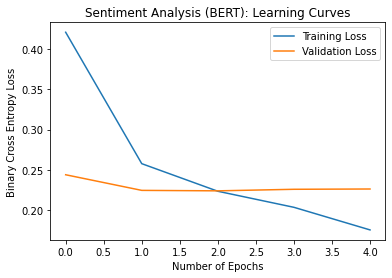

In [25]:
plt.title("Sentiment Analysis (BERT): Learning Curves")
plt.xlabel("Number of Epochs")
plt.ylabel("Binary Cross Entropy Loss")
plt.plot(train_losses, label = "Training Loss")
plt.plot(valid_losses, label= "Validation Loss")
plt.legend()
plt.show()

# Testing

In [26]:
model.load_state_dict(torch.load('BERT.pt'))

test_loss, test_acc = Evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc*100:.2f}%')

Test Loss: 0.2166
Test Accuracy: 91.44%


# Sampling

In [27]:
def predict_sentiment(model, text):
    model.eval()
    tokenized = tokenizer.tokenize(text)
    tokenized = tokenized[:max_input_length-2]
    indexed = [tokenizer.cls_token_id] + tokenizer.convert_tokens_to_ids(tokenized) + [tokenizer.sep_token_id]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    prediction = torch.sigmoid(model(tensor))
    return prediction.item()

In [28]:
predict_sentiment(model, "This film is not bad")

0.4289032518863678

In [29]:
predict_sentiment(model, "This film is excellent")

0.8496586084365845

In [37]:
predict_sentiment(model, "This film is bad")

0.04201238974928856